In [1]:
plot_count=1

In [3]:
!pip install -r requirements.txt

In [4]:
from pylab import *

In [5]:
rcParams['figure.figsize'] = 12,9
rcParams['axes.grid'] = True
rcParams['font.size'] = 20
rcParams['lines.linewidth'] = 3
DEFAULT_COLORS = rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines
import torch
from torch import optim, nn
import copy
import torch.nn.functional as F
import sys
import scipy
import scipy.linalg

from init import *
from NTK import *
from util_linnet import *
from NNGP_vs_NTK import *
from MSE import *
from matplotlib.lines import Line2D

In [7]:
def reset_colors():
    plt.rc('axes', prop_cycle=cycler(color=DEFAULT_COLORS))    

def set_colors(count):
    colors = [get_cmap('inferno')(1. * i/count) for i in range(count)][::-1]
    plt.rc('axes', prop_cycle=cycler(color=colors))

In [8]:
x = torch.linspace(-5, 5, 5000).unsqueeze(1)

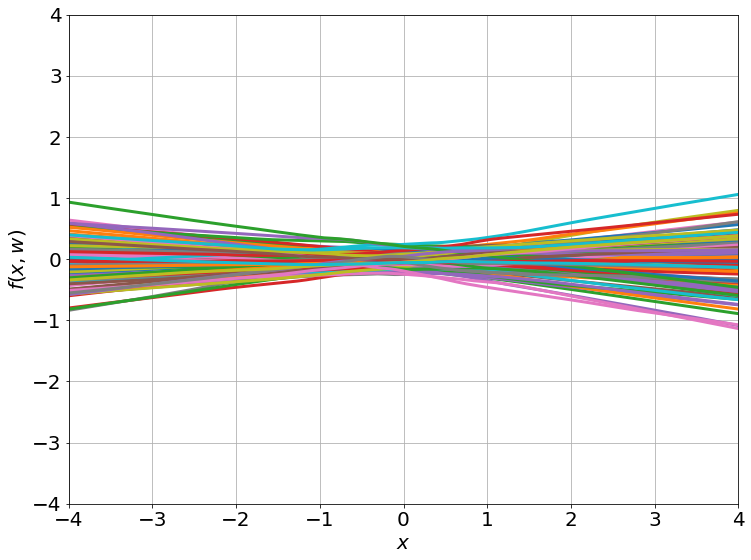

In [9]:
reset_colors()
m = 1000
b = True
count = 100
for i in range(count):
    f = simple_net(width=m, bias=b, zero_output=False, hidden_layers=2)
    plot(x.detach(), f(x).detach())
xlabel("$x$")
ylabel("$f(x, w)$")
ylim(-4, 4)
xlim(-4, 4)
savefig("net_funcs_1000.png", bbox_inches='tight')
show()

In [10]:
data= np.linspace(-1, 1, 1000)
gamma_data = torch.tensor(np.linspace(-2.5, 2.5, 4))
input_data = circle_transform(gamma_data)
target_data = torch.tensor(np.random.choice(data, 4)).float()
gamma_test = torch.tensor(np.linspace(-np.pi, np.pi, 100))
test_data = circle_transform(gamma_test)
n_train = len(gamma_data)
n_test = len(gamma_test)

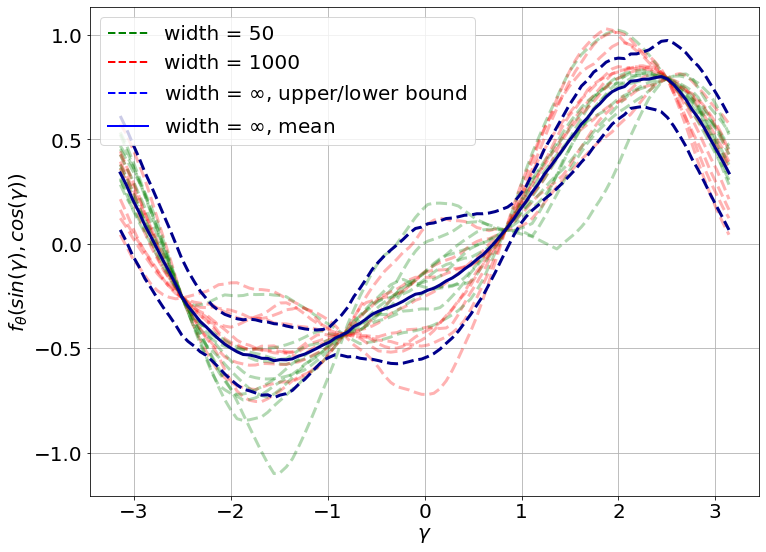

In [11]:
reset_colors()

for i in range(10):
# 1000 width first
    net = TwoLayersNet(1000)
    train_net(net, 1000, input_data, target_data)
    output_vec = net(test_data).cpu()
    plot(gamma_test.numpy(), output_vec.detach().numpy(), color='red', linestyle='--', alpha = 0.3)
# 50 width
    net = TwoLayersNet(50)
    train_net(net, 1000, input_data, target_data)
    output_vec = net(test_data).cpu()
    plot(gamma_test.numpy(), output_vec.detach().numpy(), color='green',linestyle='--', alpha = 0.3)

net = TwoLayersNet(1000)
K_testvtrain, K_trainvtrain = kernel_mats(net, gamma_data, gamma_test, kernels = 'both')
K_trainvtrain_inv = torch.inverse(K_trainvtrain)

n_pts=100
temp_mat = torch.mm(K_testvtrain, K_trainvtrain_inv)
target_data = target_data.cpu()

mean_vec = torch.mm(temp_mat, target_data.unsqueeze(1))
variance_vec = variance_est(10000, 100, temp_mat, 10000)

plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+1.28*np.sqrt(variance_vec.detach().numpy()), 
     color='darkblue', linestyle = '--')
plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()-1.28*np.sqrt(variance_vec.detach().numpy()), 
     color='darkblue', linestyle = '--')
plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+0*np.sqrt(variance_vec.detach().numpy()), 
     color='darkblue')

custom_lines = [Line2D([0], [0], color="green", lw=2, ls = "--"),
                Line2D([0], [0], color="red", lw=2, ls = "--"),
                Line2D([0], [0], color="blue", lw=2, ls = "--"),
                Line2D([0], [0], color="blue", lw=2)]

legend(custom_lines, ['width = 50', 'width = 1000', 'width = $\infty$, upper/lower bound', 'width = $\infty$, mean'])
xlabel('$\gamma$')
ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
savefig("plot_nn.png", bbox_inches='tight')
show()

/Users/nguyenthaongan/Desktop/fyp/NNGP_vs_NTK.py:175: RuntimeWarning: invalid value encountered in sqrt
  stdv_NTK = np.sqrt(s2)


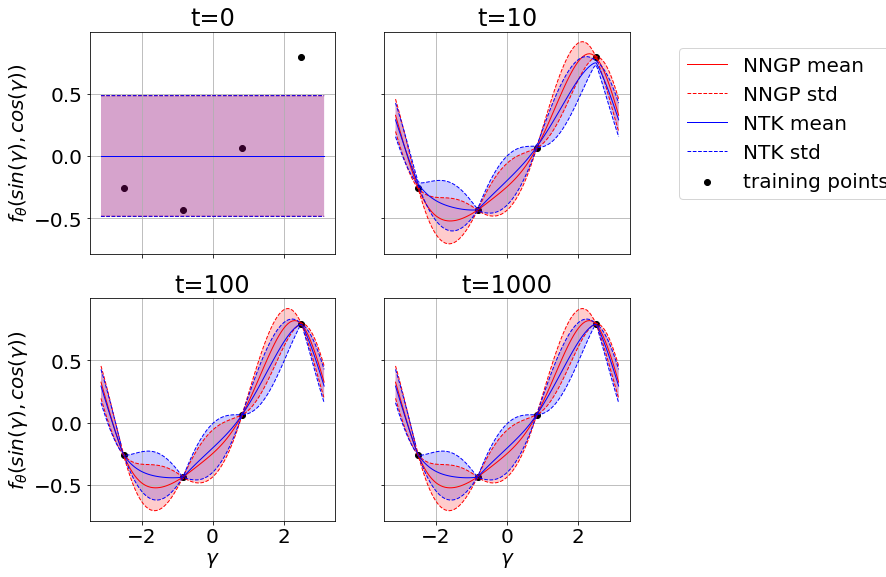

<Figure size 864x648 with 0 Axes>

In [12]:
#@title Plot
bias_variance = 0.01
variance = 1
input_dim = 2
num_hidden_layers = 2
eta = 1

deepArcCosine = DeepArcCosine(input_dim = input_dim, num_steps = num_hidden_layers, variance=variance, bias_variance = bias_variance)

X = input_data
Y = target_data
X_star = test_data

# NNGP prior and posterior
nngp = NNGP(deepArcCosine,X,Y,X_star)
prior_std = nngp.prior_std()
posterior_mean = nngp.posterior_mean()
posterior_std = nngp.posterior_std()

# get the NNGP kernels
K = nngp.get_K()
K_star = nngp.get_Kstar()
K_ss = nngp.get_Kss()

# get NTK at time t 
times = np.array([0,10,100,1000])
NTK_means = np.zeros((4,X_star.shape[0]))
NTK_stds = np.zeros((4,X_star.shape[0]))

for i in range(4):
  myNTK = NTK_analytic_pred(deepArcCosine,X,Y,X_star,times[i],eta,K,K_star,K_ss)
  NTK_means[i] = myNTK.NTK_mean()
  NTK_stds[i] = myNTK.NTK_std()

# plot 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

ax1.scatter(gamma_data.cpu().numpy(), target_data.cpu().numpy(), color='black')
ax1.plot(gamma_test.cpu().numpy(), np.zeros(X_star.shape[0]), color='red',
           linestyle='-', alpha = 1,  linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), 1.28*prior_std, color='red',
           linestyle='--', alpha = 1,  linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), -1.28*prior_std, color='red',
           linestyle='--', alpha = 1, linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), NTK_means[0], color='blue',
           linestyle='-', alpha = 1,  linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), NTK_means[0]+1.28*NTK_stds[0], color='blue',
           linestyle='--', alpha = 1,  linewidth = 1)
ax1.plot(gamma_test.cpu().numpy(), NTK_means[0]-1.28*NTK_stds[0], color='blue',
           linestyle='--', alpha = 1, linewidth = 1)
ax1.fill_between(gamma_test.cpu().numpy(), 1.28*prior_std, -1.28*prior_std, facecolor='blue', alpha=0.2)
ax1.fill_between(gamma_test.cpu().numpy(), 1.28*prior_std, -1.28*prior_std, facecolor='red', alpha=0.2)
ax1.set_title('t=%i' %times[0])

ax2.scatter(gamma_data.cpu().numpy(), target_data.cpu().numpy(), color='black')
ax2.plot(gamma_test.cpu().numpy(), posterior_mean, color='red',
           linestyle='-', alpha = 1,  linewidth = 1)
ax2.plot(gamma_test.cpu().numpy(), posterior_mean+1.28*posterior_std, color='red',
           linestyle='--', alpha = 1,  linewidth = 1)
ax2.plot(gamma_test.cpu().numpy(), posterior_mean-1.28*posterior_std, color='red',
           linestyle='--', alpha = 1, linewidth = 1)
ax2.plot(gamma_test.cpu().numpy(), NTK_means[1], color='blue',
           linestyle='-', alpha = 1,  linewidth = 1)
ax2.plot(gamma_test.cpu().numpy(), NTK_means[1]+1.28*NTK_stds[1], color='blue',
           linestyle='--', alpha = 1,  linewidth = 1)
ax2.plot(gamma_test.cpu().numpy(), NTK_means[1]-1.28*NTK_stds[1], color='blue',
           linestyle='--', alpha = 1, linewidth = 1)
ax2.fill_between(gamma_test.cpu().numpy(), NTK_means[1]+1.28*NTK_stds[1], NTK_means[1]-1.28*NTK_stds[1], facecolor='blue', alpha=0.2)
ax2.fill_between(gamma_test.cpu().numpy(), posterior_mean+1.28*posterior_std, posterior_mean-1.28*posterior_std, facecolor='red', alpha=0.2)
ax2.set_title('t=%i' %times[1])


ax3.scatter(gamma_data.cpu().numpy(), target_data.cpu().numpy(), color='black')
ax3.plot(gamma_test.cpu().numpy(), posterior_mean, color='red',
           linestyle='-', alpha = 1,  linewidth = 1)
ax3.plot(gamma_test.cpu().numpy(), posterior_mean+1.28*posterior_std, color='red',
           linestyle='--', alpha = 1,  linewidth = 1)
ax3.plot(gamma_test.cpu().numpy(), posterior_mean-1.28*posterior_std, color='red',
           linestyle='--', alpha = 1, linewidth = 1)
ax3.plot(gamma_test.cpu().numpy(), NTK_means[2], color='blue',
           linestyle='-', alpha = 1,  linewidth = 1)
ax3.plot(gamma_test.cpu().numpy(), NTK_means[2]+1.28*NTK_stds[2], color='blue',
           linestyle='--', alpha = 1,  linewidth = 1)
ax3.plot(gamma_test.cpu().numpy(), NTK_means[2]-1.28*NTK_stds[2], color='blue',
           linestyle='--', alpha = 1, linewidth = 1)
ax3.fill_between(gamma_test.cpu().numpy(), NTK_means[2]+1.28*NTK_stds[2], NTK_means[2]-1.28*NTK_stds[2], facecolor='blue', alpha=0.2)
ax3.fill_between(gamma_test.cpu().numpy(), posterior_mean+1.28*posterior_std, posterior_mean-1.28*posterior_std, facecolor='red', alpha=0.2)
ax3.set_title('t=%i' %times[2])

ax4.scatter(gamma_data.cpu().numpy(), target_data.cpu().numpy(), color='black',label = 'training points')
ax4.plot(gamma_test.cpu().numpy(), posterior_mean, color='red',
           linestyle='-', alpha = 1,  label = 'NNGP mean', linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), posterior_mean+1.28*posterior_std, color='red',
           linestyle='--', alpha = 1,  label = 'NNGP std', linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), posterior_mean-1.28*posterior_std, color='red',
           linestyle='--', alpha = 1, linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), NTK_means[3], color='blue',
           linestyle='-', alpha = 1,  label = 'NTK mean', linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), NTK_means[3]+1.28*NTK_stds[3], color='blue',
           linestyle='--', alpha = 1,  label = 'NTK std', linewidth = 1)
ax4.plot(gamma_test.cpu().numpy(), NTK_means[3]-1.28*NTK_stds[3], color='blue',
           linestyle='--', alpha = 1, linewidth = 1)
ax4.fill_between(gamma_test.cpu().numpy(), NTK_means[3]+1.28*NTK_stds[3], NTK_means[3]-1.28*NTK_stds[3], facecolor='blue', alpha=0.2)
ax4.fill_between(gamma_test.cpu().numpy(), posterior_mean+1.28*posterior_std, posterior_mean-1.28*posterior_std, facecolor='red', alpha=0.2)
ax4.set_title('t=%i' %times[3])

ax3.set_xlabel('$\gamma$')
ax4.set_xlabel('$\gamma$')
ax1.set_ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
ax3.set_ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
handles, labels = plt.gca().get_legend_handles_labels()
f.subplots_adjust(right=0.75) 
f.legend(loc=7,bbox_to_anchor = (1.05, 0.7))
plt.show()
plt.savefig("NNGP_vs_NTK.png")


In [13]:
n_width = 5000
# instanciate network
net = TwoLayersNet(n_width).to("cpu")

In [14]:
initial_train = net(input_data).reshape(-1)
gamma_test = torch.tensor(np.linspace(-np.pi, np.pi, 10))
test_data = circle_transform(gamma_test)
initial_test = net(test_data)
n_test = len(gamma_test)

In [15]:
%%time
grad_list = compute_grad_list(net, gamma_data)
grad_tensor = unpack_gradients(grad_list)
n_parameters = grad_tensor.shape[1]

CPU times: user 11.6 ms, sys: 2.72 ms, total: 14.4 ms
Wall time: 20.1 ms


In [16]:
%%time
theta_0_test, theta_0 = kernel_mats(net, gamma_data, gamma_test, kernels='both')  

CPU times: user 34.4 ms, sys: 3.16 ms, total: 37.6 ms
Wall time: 49.9 ms


In [17]:
weights_initial_GD = obtain_weights(net)

In [18]:
lr = 0.1
t_max = 1000
t_step = 30
n_weights_to_track = 10

random_indices = np.random.randint(0, n_parameters, n_weights_to_track)
t_list = np.arange(0, t_max, t_step)

weights_GD_evolution = np.zeros((n_weights_to_track, len(t_list)))
weights_analytical_evolution = np.zeros((n_weights_to_track, len(t_list)))

preds_train_GD_evolution = np.zeros((n_train, len(t_list)))
preds_train_analytical_evolution = np.zeros((n_train, len(t_list)))

preds_test_GD_evolution = np.zeros((n_test, len(t_list)))
preds_test_analytical_evolution = np.zeros((n_test, len(t_list)))

In [19]:
training_time = 0
analytical_time = 0

for i, t in tqdm(enumerate(t_list)): 
  
  # train network
  start_time = time.time()
  train_net(net, t_step, input_data, target_data, lr=lr)
  
  # extract_weights
  weights_GD = list(net.parameters())
  weights_GD = unpack_weights(weights_GD).detach().cpu().numpy()
  
  # save the interesting ones: 
  weights_GD_evolution[:, i] = weights_GD[random_indices] - weights_initial_GD[random_indices]

  # compute the preciction on the trainset at this point of the training: 
  preds_train_GD_evolution[:, i] = net(input_data).detach().cpu().reshape(-1)
  
  # same on the testset: 
  preds_test_GD_evolution[:, i] = net(test_data).detach().cpu().reshape(-1)  
  training_time += time.time() - start_time
  
      
  # now compute the analytical evolution: 
  # this is extremely efficient as at every step we compute the eigendecomposition and some matrix multiplication that remain the same with different t
  start_time = time.time()
  
  results = analytical_evolution_MSE(t, lr, theta_0, theta_0_test, initial_train, initial_test, target_data, grad_tensor[:, random_indices])
  weights_analytical_evolution[:, i] = results[0]
  preds_train_analytical_evolution[:, i] = results[1]
  preds_test_analytical_evolution[:, i] = results[2]
  analytical_time += time.time() - start_time

print("\nNN training time: {:.2f}, analytical computation time: {:.2f}.".format(training_time, analytical_time))

34it [00:00, 34.49it/s]


NN training time: 0.96, analytical computation time: 0.02.


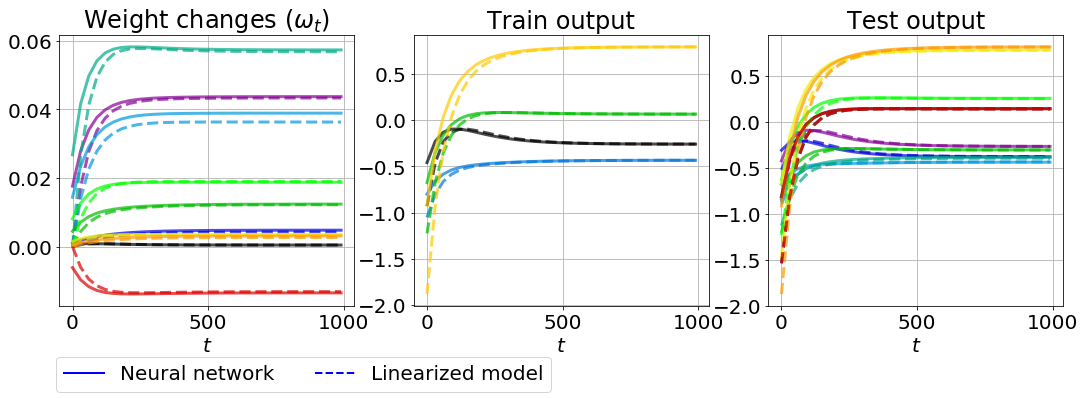

<Figure size 864x648 with 0 Axes>

In [20]:
cmap = plt.cm.nipy_spectral
alpha = 0.7

fig, ax = plt.subplots(1,3, figsize=(18,5))

for i in range(n_weights_to_track):  
  ax[0].set_title(r"Weight changes $(\omega_t)$")
  ax[0].set_xlabel(r"$t$")
  ax[0].plot(t_list, weights_analytical_evolution[i], "--", color=cmap(i/n_weights_to_track), alpha=alpha)
  ax[0].plot(t_list, weights_GD_evolution[i], color=cmap(i/n_weights_to_track), alpha=alpha)
   
for i in range(n_train):
  ax[1].set_title(r"Train output")
  ax[1].set_xlabel(r"$t$")
  ax[1].plot(t_list, preds_train_analytical_evolution[i], "--", color=cmap(i/n_train), alpha=alpha)
  ax[1].plot(t_list, preds_train_GD_evolution[i], color=cmap(i/n_train), alpha=alpha)
  
for i in range(n_test):
  ax[2].set_title(r"Test output")
  ax[2].set_xlabel(r"$t$")
  ax[2].plot(t_list, preds_test_analytical_evolution[i], "--", color=cmap(i/n_test), alpha=alpha)
  ax[2].plot(t_list, preds_test_GD_evolution[i], color=cmap(i/n_test), alpha=alpha)
custom_lines = [Line2D([0], [0], color="blue", lw=2),
                Line2D([0], [0], color="blue", lw=2, ls="--")]
ax[1].legend(custom_lines, ['Neural network', 'Linearized model'], loc = 5, bbox_to_anchor = (0.5, -0.25), ncol=2)

plt.show()

plt.savefig("linear_evolution.png")